# Stock Price Predictor - Final Notebook
Kevin Jin, Ho Hin Lee, Tiancheng Li, Yuchen Li

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import json
%matplotlib inline
import math
import time
import datetime

import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
from pandas import datetime
from pandas_datareader import data

stock = 'AAPL'
start = datetime(2016,3,19)
end = datetime(2018,5,1)

df = data.DataReader(stock, 'iex', start, end)

y = df['close']
y1 = y.iloc[1:]
y1 = (np.append(y1,[0]))
y2 = y.iloc[5:]
y2 = (np.append(y2,[0,0,0,0,0]))
df['price+1'] = y1 #future price
df['price+5'] = y2

df.head()

5y


,open,high,low,close,volume,price+1,price+5
date,,,,,,,
2016-03-21,102.1213,103.7794,101.3598,102.1020,35502678,102.8829,103.8084
2016-03-22,101.4657,103.4324,101.4272,102.8829,32444375,102.3141,105.6208
2016-03-23,102.6515,103.2203,102.0924,102.3141,25703495,101.8706,105.0713
2016-03-24,101.6778,102.4298,101.1187,101.8706,26132955,101.4079,106.0353
2016-03-28,102.1888,102.3719,101.2826,101.4079,19411372,103.8084,107.1247


D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,close,volume,price+1,price+5,macd,rsi_12,volume_delta,MA 20,MA 50,Daily Change,Fluctuation
date,,,,,,,,,,,
2017-01-03,113.8474,28781865,113.7200,116.7488,1.277287,52.196938,-1804400.0,112.612895,110.465704,0.3430,1.368094
2017-01-04,113.7200,21118116,114.2983,117.3761,1.188925,49.671961,-7663749.0,112.951545,110.466010,0.1666,0.656558
2017-01-05,114.2983,22193587,115.5725,116.8860,1.152279,60.167694,1075471.0,113.277945,110.457402,0.6763,0.910283
2017-01-06,115.5725,31751900,116.6311,116.6801,1.212082,74.324962,9558313.0,113.615125,110.462576,1.1076,1.451020
2017-01-09,116.6311,33561948,116.7488,117.6211,1.329570,81.042392,1810048.0,113.951815,110.540802,1.0193,1.263300


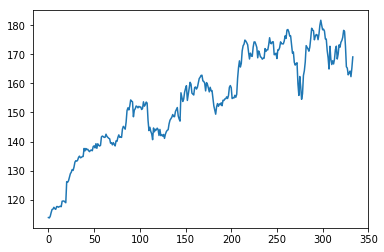

In [3]:
from stockstats import StockDataFrame
df = StockDataFrame.retype(df)
y = df['close']

#generate features with stockstats package
df['macd'] = df.get('macd')
df['rsi_12'] = df.get('rsi_6')
df['volume_delta'] = df.get('volume_delta')
df['MA 20'] = y.rolling(20).mean()
df['MA 50'] = y.rolling(50).mean()
df['Daily Change'] = df['close']-df['open']
df['Fluctuation'] = ((df['high']-df['low'])/df['low'])*100
df.tail(10)
df = pd.DataFrame(df)

X = df.drop(['open', 'high', 'low', 'macdh', 'macds', 'close_-1_s', 'close_-1_d', 'rs_6', 'rsi_6', 'close_12_ema', 'close_26_ema'], axis=1)
X_shape = X.shape[0]
X1 = X['20160103':]
y = X1['close']
y_max = np.max(np.array(y))
y_min = np.min(np.array(y))
plt.plot(np.array(y))
X1.head()



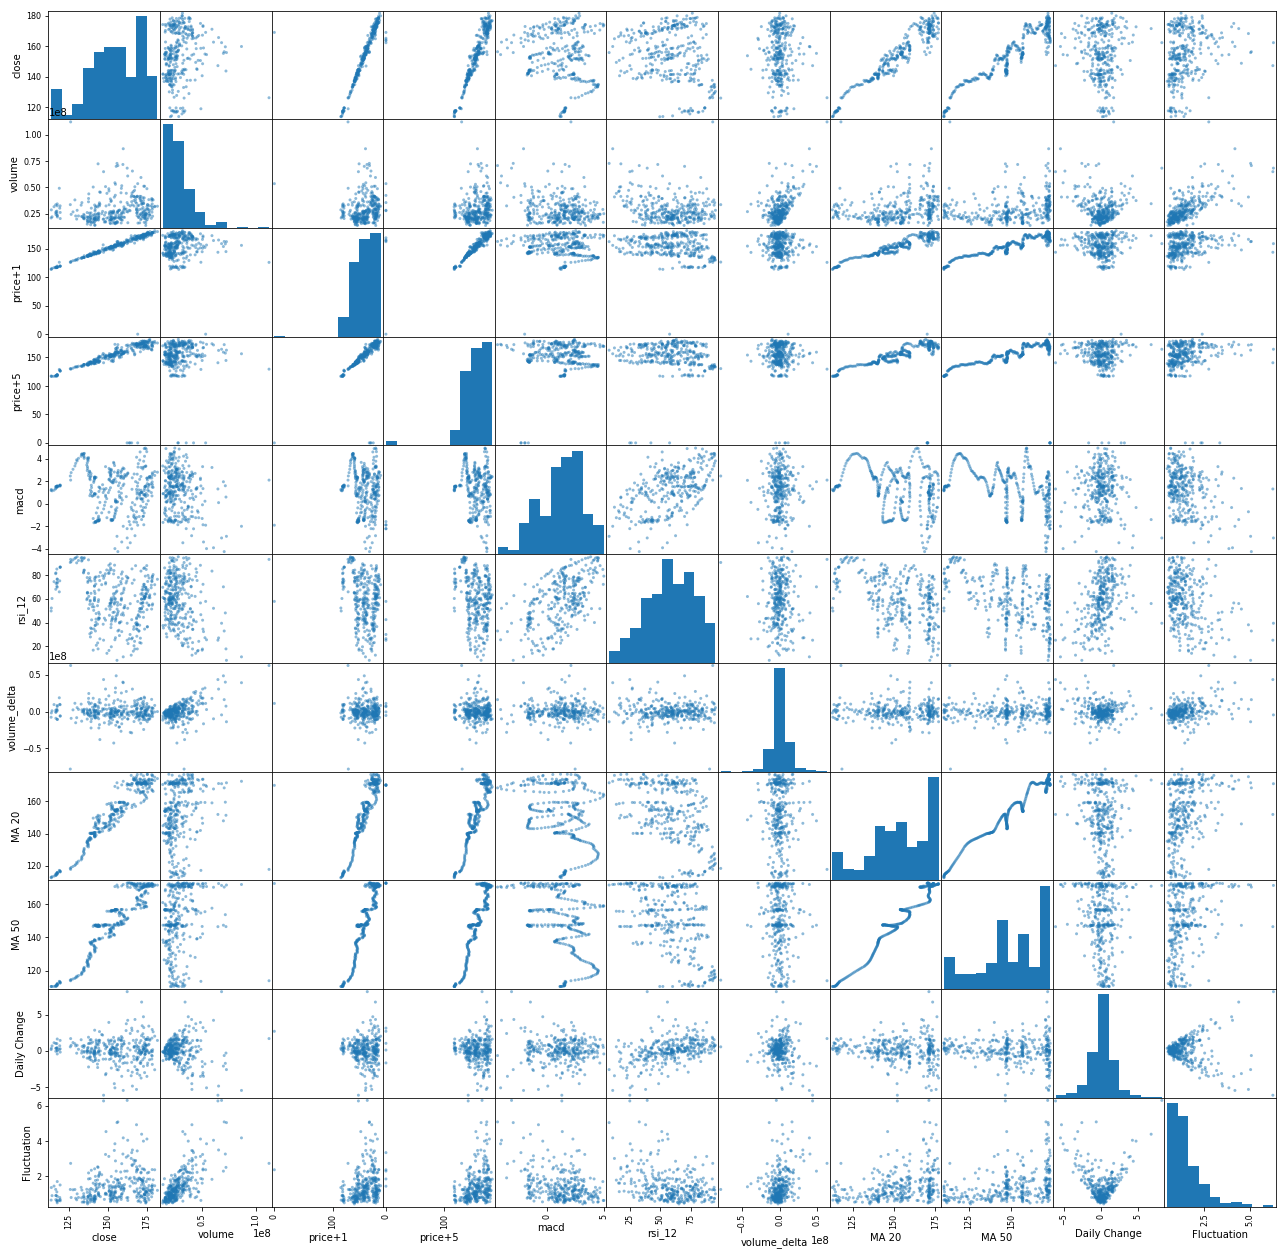

In [4]:
from pandas.plotting import scatter_matrix
scatter_matrix(X1,figsize=(22,22))
plt.show()

- As seen above, there does not seem to be much related correlations to that of the closing price and future prices except that of the moving averages. Therefore, we can see that this data does not follow any linear trend

In [5]:
from sklearn.preprocessing import MinMaxScaler

def normalize_df(df):
    normalize_data = MinMaxScaler()
    for i in range(0,df.shape[1]):
        df.iloc[:,i] = normalize_data.fit_transform(df.iloc[:,i].values.reshape(-1,1))
    return df

def coeff_determination(y_true,y_pred):
    SS_res = np.sum((y_true-y_pred)**2)
    SS_tot = np.sum((y_true-np.mean(y_true))**2)
    return(np.abs(1-SS_res/(SS_tot+1e-18)))


def RMSE_calc(X_test,y_test,y_max,y_min,model):
    y_validation = model.predict(X_test)
    y_validation_scaled = np.ravel(np.array(y_validation)) #*(y_max-y_min)+y_min))
    y_actual_scaled = np.array(np.array(y_test)) #*(y_max-y_min)+y_min)
    RMSE = ((np.sum((y_validation_scaled-y_actual_scaled)**(2)))**(0.5))/y_test.shape[0]
    return RMSE

In [6]:
X2 = normalize_df(X1)
y_normal = X2['close']


X3 = X2.drop(['close','price+1','price+5'], axis = 1)
print(X3.shape)
X3.tail(10)

time_length = X3.shape[0]

D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


(334, 8)


## Test with LSTM Neural Network

In [27]:
window = 10 #prediction time-lag window

def load_data(stock,y,window):
    raw_data = stock.as_matrix()
    length = raw_data.shape[0]
    indicators = raw_data.shape[1]    
    prices = y.as_matrix()
    data = []

    for index in range(len(raw_data)-(window)+1):
        data.append(raw_data[index:index+window])
    
    data = np.array(data)
    valid_size = int(np.round(2/100*data.shape[0]))
    test_size = int(1)
    training_size = data.shape[0] - (valid_size + test_size)
    
    X_train = data[:training_size+valid_size,:-1]
    y_train = prices[window-1:training_size+window+valid_size-1]
    
    #validation for time series
    X_valid = data[training_size:training_size+valid_size,:-1]
    y_valid = prices[training_size+window-1:training_size+valid_size+window-1]
    
    #X_valid = data[training_size+valid_size:,:-1]
    #y_valid = prices[-1]
    
    raw_data = raw_data.reshape(1,length,indicators)
    
    X_test = np.zeros((1,window,8))
    for i in range(0,window-1):
        X_test[0,window-1-i,:] = raw_data[0,length-i-1,:]
    X_test = X_test[:,1:,:]
    y_test = 0
    
    return [X_train, y_train, X_valid, y_valid, X_test, y_test]

In [28]:
X_train, y_train, X_valid, y_valid, X_test, y_test = load_data(X3,y_normal,window+1)
print(X_valid.shape)
print(X_test)

(6, 10, 8)
[[[ 0.06868086  0.57016102  0.72616669  0.51342978  0.91143289  0.98863706
    0.43121081  0.11194523]
  [ 0.21215265  0.55065561  0.41511658  0.65454245  0.91262218  0.9919809
    0.27881974  0.19442692]
  [ 0.52537081  0.47300862  0.21647941  0.77242302  0.91018919  0.99416947
    0.0883309   0.52102397]
  [ 0.22957512  0.40788456  0.20692284  0.34949262  0.91042238  0.99760562
    0.31763053  0.21886748]
  [ 0.20075206  0.33754333  0.16166295  0.53489208  0.90278139  0.9996987
    0.23827532  0.46491524]
  [ 0.14654604  0.28999856  0.20874143  0.51726486  0.89913579  1.
    0.50111497  0.24077915]
  [ 0.142268    0.25964295  0.24962867  0.5519374   0.89737906  0.99996154
    0.4361041   0.17117035]
  [ 0.22079958  0.22169742  0.19390191  0.60944464  0.89313493  0.99834284
    0.31167469  0.31742709]
  [ 0.28992675  0.22017756  0.39297153  0.60291374  0.89203114  0.99586512
    0.64789973  0.4954774 ]
  [ 0.40366846  0.25501237  0.56902219  0.63389636  0.89258304  0.994797

In [29]:
from keras.models import Sequential
from keras import regularizers
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model

def build_model(layers,neurons,d):
    #d = 0.3
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))   
    #used small L2 regularization here because it makes k folds CV more consistent
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))  
    
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

model = build_model([X3.shape[1],window,1],[256,256,32,1],0.3)

Compilation Time :  0.011530876159667969


In [10]:
#find optimal number of epochs to run for neural network
epochs = [30,45,50,60,80,90,100,120]
RMSE_all = []
model = build_model([X3.shape[1],window,1],[256,256,32,1],0.3)

for epoch in epochs:
    model.fit(X_train,y_train,batch_size=512,epochs=epoch,validation_split=0.1,verbose=1)
    y_validation = model.predict(X_valid)
    RMSE = RMSE_calc(X_valid,y_valid,y_max,y_min,model)
    RMSE_all.append(RMSE)
print(RMSE_all)


Compilation Time :  0.013035297393798828
Train on 290 samples, validate on 33 samples
Epoch 1/30
290/290 [==============================] - 1s 4ms/step - loss: 0.3982 - acc: 0.0000e+00 - val_loss: 0.6848 - val_acc: 0.0000e+00
Epoch 2/30
290/290 [==============================] - 0s 131us/step - loss: 0.3855 - acc: 0.0000e+00 - val_loss: 0.6560 - val_acc: 0.0000e+00
Epoch 3/30
290/290 [==============================] - 0s 128us/step - loss: 0.3671 - acc: 0.0000e+00 - val_loss: 0.6117 - val_acc: 0.0000e+00
Epoch 4/30
290/290 [==============================] - 0s 131us/step - loss: 0.3389 - acc: 0.0000e+00 - val_loss: 0.5392 - val_acc: 0.0000e+00
Epoch 5/30
290/290 [==============================] - 0s 128us/step - loss: 0.2944 - acc: 0.0000e+00 - val_loss: 0.4221 - val_acc: 0.0000e+00
Epoch 6/30
290/290 [==============================] - 0s 133us/step - loss: 0.2235 - acc: 0.0000e+00 - val_loss: 0.2558 - val_acc: 0.0000e+00
Epoch 7/30
290/290 [==============================] - 0s 126us/s

Epoch 29/45
290/290 [==============================] - 0s 118us/step - loss: 0.0087 - acc: 0.0034 - val_loss: 0.0080 - val_acc: 0.0000e+00
Epoch 30/45
290/290 [==============================] - 0s 131us/step - loss: 0.0081 - acc: 0.0034 - val_loss: 0.0064 - val_acc: 0.0000e+00
Epoch 31/45
290/290 [==============================] - 0s 114us/step - loss: 0.0072 - acc: 0.0034 - val_loss: 0.0056 - val_acc: 0.0000e+00
Epoch 32/45
290/290 [==============================] - 0s 118us/step - loss: 0.0080 - acc: 0.0034 - val_loss: 0.0055 - val_acc: 0.0000e+00
Epoch 33/45
290/290 [==============================] - 0s 114us/step - loss: 0.0081 - acc: 0.0034 - val_loss: 0.0059 - val_acc: 0.0000e+00
Epoch 34/45
290/290 [==============================] - 0s 118us/step - loss: 0.0077 - acc: 0.0034 - val_loss: 0.0075 - val_acc: 0.0000e+00
Epoch 35/45
290/290 [==============================] - 0s 118us/step - loss: 0.0071 - acc: 0.0034 - val_loss: 0.0097 - val_acc: 0.0000e+00
Epoch 36/45
290/290 [======

Epoch 43/50
290/290 [==============================] - 0s 118us/step - loss: 0.0044 - acc: 0.0034 - val_loss: 0.0069 - val_acc: 0.0000e+00
Epoch 44/50
290/290 [==============================] - 0s 114us/step - loss: 0.0043 - acc: 0.0034 - val_loss: 0.0063 - val_acc: 0.0000e+00
Epoch 45/50
290/290 [==============================] - 0s 114us/step - loss: 0.0045 - acc: 0.0034 - val_loss: 0.0049 - val_acc: 0.0000e+00
Epoch 46/50
290/290 [==============================] - 0s 121us/step - loss: 0.0040 - acc: 0.0034 - val_loss: 0.0048 - val_acc: 0.0000e+00
Epoch 47/50
290/290 [==============================] - 0s 124us/step - loss: 0.0043 - acc: 0.0034 - val_loss: 0.0066 - val_acc: 0.0000e+00
Epoch 48/50
290/290 [==============================] - 0s 114us/step - loss: 0.0037 - acc: 0.0034 - val_loss: 0.0076 - val_acc: 0.0000e+00
Epoch 49/50
290/290 [==============================] - 0s 111us/step - loss: 0.0043 - acc: 0.0034 - val_loss: 0.0060 - val_acc: 0.0000e+00
Epoch 50/50
290/290 [======

Epoch 52/60
290/290 [==============================] - 0s 121us/step - loss: 0.0032 - acc: 0.0034 - val_loss: 0.0046 - val_acc: 0.0000e+00
Epoch 53/60
290/290 [==============================] - 0s 123us/step - loss: 0.0032 - acc: 0.0034 - val_loss: 0.0046 - val_acc: 0.0000e+00
Epoch 54/60
290/290 [==============================] - 0s 118us/step - loss: 0.0033 - acc: 0.0034 - val_loss: 0.0053 - val_acc: 0.0000e+00
Epoch 55/60
290/290 [==============================] - 0s 121us/step - loss: 0.0031 - acc: 0.0034 - val_loss: 0.0037 - val_acc: 0.0000e+00
Epoch 56/60
290/290 [==============================] - 0s 114us/step - loss: 0.0034 - acc: 0.0034 - val_loss: 0.0063 - val_acc: 0.0000e+00
Epoch 57/60
290/290 [==============================] - 0s 114us/step - loss: 0.0036 - acc: 0.0034 - val_loss: 0.0059 - val_acc: 0.0000e+00
Epoch 58/60
290/290 [==============================] - 0s 114us/step - loss: 0.0036 - acc: 0.0034 - val_loss: 0.0032 - val_acc: 0.0000e+00
Epoch 59/60
290/290 [======

Epoch 51/80
290/290 [==============================] - 0s 118us/step - loss: 0.0026 - acc: 0.0034 - val_loss: 0.0054 - val_acc: 0.0000e+00
Epoch 52/80
290/290 [==============================] - 0s 118us/step - loss: 0.0032 - acc: 0.0034 - val_loss: 0.0036 - val_acc: 0.0000e+00
Epoch 53/80
290/290 [==============================] - 0s 121us/step - loss: 0.0029 - acc: 0.0034 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 54/80
290/290 [==============================] - 0s 114us/step - loss: 0.0030 - acc: 0.0034 - val_loss: 0.0054 - val_acc: 0.0000e+00
Epoch 55/80
290/290 [==============================] - 0s 114us/step - loss: 0.0031 - acc: 0.0034 - val_loss: 0.0038 - val_acc: 0.0000e+00
Epoch 56/80
290/290 [==============================] - 0s 114us/step - loss: 0.0028 - acc: 0.0034 - val_loss: 0.0036 - val_acc: 0.0000e+00
Epoch 57/80
290/290 [==============================] - 0s 118us/step - loss: 0.0025 - acc: 0.0034 - val_loss: 0.0044 - val_acc: 0.0000e+00
Epoch 58/80
290/290 [======

Epoch 30/90
290/290 [==============================] - 0s 121us/step - loss: 0.0033 - acc: 0.0034 - val_loss: 0.0022 - val_acc: 0.0000e+00
Epoch 31/90
290/290 [==============================] - 0s 121us/step - loss: 0.0030 - acc: 0.0034 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 32/90
290/290 [==============================] - 0s 118us/step - loss: 0.0028 - acc: 0.0034 - val_loss: 0.0074 - val_acc: 0.0000e+00
Epoch 33/90
290/290 [==============================] - 0s 114us/step - loss: 0.0035 - acc: 0.0034 - val_loss: 0.0039 - val_acc: 0.0000e+00
Epoch 34/90
290/290 [==============================] - 0s 124us/step - loss: 0.0024 - acc: 0.0034 - val_loss: 0.0022 - val_acc: 0.0000e+00
Epoch 35/90
290/290 [==============================] - 0s 123us/step - loss: 0.0037 - acc: 0.0034 - val_loss: 0.0045 - val_acc: 0.0000e+00
Epoch 36/90
290/290 [==============================] - 0s 130us/step - loss: 0.0025 - acc: 0.0034 - val_loss: 0.0069 - val_acc: 0.0000e+00
Epoch 37/90
290/290 [======

Epoch 89/90
290/290 [==============================] - 0s 114us/step - loss: 0.0031 - acc: 0.0034 - val_loss: 0.0040 - val_acc: 0.0000e+00
Epoch 90/90
290/290 [==============================] - 0s 114us/step - loss: 0.0024 - acc: 0.0034 - val_loss: 0.0022 - val_acc: 0.0000e+00
Train on 290 samples, validate on 33 samples
Epoch 1/100
290/290 [==============================] - 0s 116us/step - loss: 0.0029 - acc: 0.0034 - val_loss: 0.0030 - val_acc: 0.0000e+00
Epoch 2/100
290/290 [==============================] - 0s 114us/step - loss: 0.0022 - acc: 0.0034 - val_loss: 0.0052 - val_acc: 0.0000e+00
Epoch 3/100
290/290 [==============================] - 0s 114us/step - loss: 0.0027 - acc: 0.0034 - val_loss: 0.0038 - val_acc: 0.0000e+00
Epoch 4/100
290/290 [==============================] - 0s 114us/step - loss: 0.0020 - acc: 0.0034 - val_loss: 0.0024 - val_acc: 0.0000e+00
Epoch 5/100
290/290 [==============================] - 0s 111us/step - loss: 0.0030 - acc: 0.0034 - val_loss: 0.0037 - va

Epoch 58/100
290/290 [==============================] - 0s 124us/step - loss: 0.0026 - acc: 0.0034 - val_loss: 0.0036 - val_acc: 0.0000e+00
Epoch 59/100
290/290 [==============================] - 0s 118us/step - loss: 0.0025 - acc: 0.0034 - val_loss: 0.0033 - val_acc: 0.0000e+00
Epoch 60/100
290/290 [==============================] - 0s 121us/step - loss: 0.0023 - acc: 0.0034 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 61/100
290/290 [==============================] - 0s 124us/step - loss: 0.0023 - acc: 0.0034 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 62/100
290/290 [==============================] - 0s 121us/step - loss: 0.0022 - acc: 0.0034 - val_loss: 0.0032 - val_acc: 0.0000e+00
Epoch 63/100
290/290 [==============================] - 0s 118us/step - loss: 0.0024 - acc: 0.0034 - val_loss: 0.0036 - val_acc: 0.0000e+00
Epoch 64/100
290/290 [==============================] - 0s 121us/step - loss: 0.0022 - acc: 0.0034 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 65/100
290/290

Epoch 17/120
290/290 [==============================] - 0s 124us/step - loss: 0.0019 - acc: 0.0034 - val_loss: 0.0023 - val_acc: 0.0000e+00
Epoch 18/120
290/290 [==============================] - 0s 118us/step - loss: 0.0021 - acc: 0.0034 - val_loss: 0.0034 - val_acc: 0.0000e+00
Epoch 19/120
290/290 [==============================] - 0s 118us/step - loss: 0.0021 - acc: 0.0034 - val_loss: 0.0037 - val_acc: 0.0000e+00
Epoch 20/120
290/290 [==============================] - 0s 118us/step - loss: 0.0021 - acc: 0.0034 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 21/120
290/290 [==============================] - 0s 118us/step - loss: 0.0022 - acc: 0.0034 - val_loss: 0.0024 - val_acc: 0.0000e+00
Epoch 22/120
290/290 [==============================] - 0s 118us/step - loss: 0.0022 - acc: 0.0034 - val_loss: 0.0044 - val_acc: 0.0000e+00
Epoch 23/120
290/290 [==============================] - 0s 118us/step - loss: 0.0021 - acc: 0.0034 - val_loss: 0.0041 - val_acc: 0.0000e+00
Epoch 24/120
290/290

Epoch 76/120
290/290 [==============================] - 0s 121us/step - loss: 0.0020 - acc: 0.0034 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 77/120
290/290 [==============================] - 0s 121us/step - loss: 0.0019 - acc: 0.0034 - val_loss: 0.0021 - val_acc: 0.0000e+00
Epoch 78/120
290/290 [==============================] - 0s 128us/step - loss: 0.0019 - acc: 0.0034 - val_loss: 0.0030 - val_acc: 0.0000e+00
Epoch 79/120
290/290 [==============================] - 0s 124us/step - loss: 0.0019 - acc: 0.0034 - val_loss: 0.0037 - val_acc: 0.0000e+00
Epoch 80/120
290/290 [==============================] - 0s 135us/step - loss: 0.0019 - acc: 0.0034 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 81/120
290/290 [==============================] - 0s 128us/step - loss: 0.0017 - acc: 0.0034 - val_loss: 0.0032 - val_acc: 0.0000e+00
Epoch 82/120
290/290 [==============================] - 0s 118us/step - loss: 0.0021 - acc: 0.0034 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 83/120
290/290

Text(0,0.5,'RMSE')

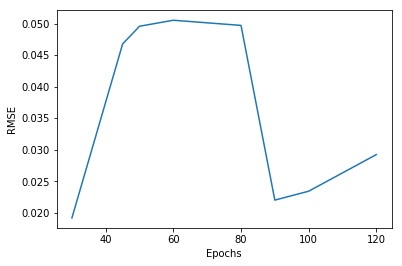

In [11]:
plt.plot(epochs,RMSE_all)
plt.xlabel("Epochs")
plt.ylabel("RMSE")


- As seen above, the best amount of epochs for this model is 120, but there is a decrease in RMSE at 90 epochs compared to 80 or 100. Additionally, having more epochs increases the computation time for the neural network, so having a low amount of epochs is good especially for a lightweight web app. Therefore, 90 epochs is chosen as the best amount due to having a lower computation time and good RMSE, and will be used for the rest of the models run in this notebook and in the web app. It is noted that regardless of whether the first choice is 30, 45 or 50, the RMSE always seems to be the lowest during the first run. Therefore, it can be considered an outlier and ignored.

In [30]:
model = build_model([X3.shape[1],window,1],[256,256,32,1],0.3)
model.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)

Compilation Time :  0.011029481887817383
Train on 290 samples, validate on 33 samples
Epoch 1/90
290/290 [==============================] - 1s 4ms/step - loss: 0.4026 - acc: 0.0000e+00 - val_loss: 0.6985 - val_acc: 0.0000e+00
Epoch 2/90
290/290 [==============================] - 0s 124us/step - loss: 0.3941 - acc: 0.0000e+00 - val_loss: 0.6806 - val_acc: 0.0000e+00
Epoch 3/90
290/290 [==============================] - 0s 135us/step - loss: 0.3829 - acc: 0.0000e+00 - val_loss: 0.6533 - val_acc: 0.0000e+00
Epoch 4/90
290/290 [==============================] - 0s 124us/step - loss: 0.3660 - acc: 0.0000e+00 - val_loss: 0.6116 - val_acc: 0.0000e+00
Epoch 5/90
290/290 [==============================] - 0s 128us/step - loss: 0.3402 - acc: 0.0000e+00 - val_loss: 0.5450 - val_acc: 0.0000e+00
Epoch 6/90
290/290 [==============================] - 0s 128us/step - loss: 0.2987 - acc: 0.0000e+00 - val_loss: 0.4415 - val_acc: 0.0000e+00
Epoch 7/90
290/290 [==============================] - 0s 124us/s

290/290 [==============================] - 0s 118us/step - loss: 0.0095 - acc: 0.0034 - val_loss: 0.0055 - val_acc: 0.0000e+00
Epoch 60/90
290/290 [==============================] - 0s 114us/step - loss: 0.0102 - acc: 0.0034 - val_loss: 0.0060 - val_acc: 0.0000e+00
Epoch 61/90
290/290 [==============================] - 0s 118us/step - loss: 0.0102 - acc: 0.0034 - val_loss: 0.0057 - val_acc: 0.0000e+00
Epoch 62/90
290/290 [==============================] - 0s 116us/step - loss: 0.0102 - acc: 0.0034 - val_loss: 0.0052 - val_acc: 0.0000e+00
Epoch 63/90
290/290 [==============================] - 0s 116us/step - loss: 0.0098 - acc: 0.0034 - val_loss: 0.0054 - val_acc: 0.0000e+00
Epoch 64/90
290/290 [==============================] - 0s 118us/step - loss: 0.0105 - acc: 0.0034 - val_loss: 0.0054 - val_acc: 0.0000e+00
Epoch 65/90
290/290 [==============================] - 0s 116us/step - loss: 0.0100 - acc: 0.0034 - val_loss: 0.0052 - val_acc: 0.0000e+00
Epoch 66/90
290/290 [==================

In [31]:
y_validation = model.predict(X_valid)

y_validation_scaled = np.ravel(np.array(y_validation)) #*(y_max-y_min)+y_min))
y_actual_scaled = np.array(np.array(y[time_length-6:]))#*(y_max-y_min)+y_min)

RMSE = ((np.sum((y_validation_scaled-y_actual_scaled)**(2)))**(0.5))/(X_valid.shape[0])

print(y_validation_scaled)
print(y_actual_scaled)
print(RMSE)

R2 = coeff_determination(y_actual_scaled,y_validation_scaled) #inaccurate
print('R^2 =',R2)

[ 0.87416977  0.87593687  0.87623888  0.87483454  0.87211901  0.86658514]
[ 0.72382353  0.73426471  0.74264706  0.71470588  0.75794118  0.81441176]
0.053208601999
R^2 = 14.8764912635


- $R^2$ calculated from the validation dataset shows that it is not a good indicator to show whether predicting future stock prices 1 day beforehand is accurate or not. It is also seen that although the predicted numbers do not mean much, but the values increased or decreased from the previous datapoint in the similar way as the actual dataset. Additionally, the RMSE can be calculated for a validation dataset which shows it to be 16.33 for 6 validation data points. Next, a prediction will be made

In [32]:
y_predict = model.predict(X_test)
y_predict_scaled = y_predict*(y_max-y_min)+y_min
print(y_predict_scaled)

#Decision based on prediction on data for tomorrow's price
y_check = y[-1]*(y_max-y_min)+y_min

print('Based on previous value of:', y_check)
if y_check < y_predict_scaled:
    print('Buy')
elif y_check > y_predict_scaled:
    print('Sell if bought')
else:
    print('error')

[[ 171.36758423]]
Based on previous value of: 169.1
Buy


In [33]:
#cross validation on 4 folds in time series
def load_data(stock,y,window):
    raw_data = stock.as_matrix()
    length = raw_data.shape[0]
    indicators = raw_data.shape[1]    
    prices = y.as_matrix()
    data = []

    for index in range(len(raw_data)-(window)+1):
        data.append(raw_data[index:index+window])
    
    data = np.array(data)
    valid_size = int(10)
    test_size = int(1)
    training_size = data.shape[0] - (valid_size + test_size)
    
    X_train = data[:training_size+valid_size,:-1]
    y_train = prices[window-1:training_size+window+valid_size-1]
    
    #validation for time series
    X_valid = data[training_size:training_size+valid_size,:-1]
    y_valid = prices[training_size+window-1:training_size+valid_size+window-1]
    
    #X_valid = data[training_size+valid_size:,:-1]
    #y_valid = prices[-1]
    
    raw_data = raw_data.reshape(1,length,indicators)
    
    X_test = np.zeros((1,window,8))
    for i in range(0,window-1):
        X_test[0,window-1-i,:] = raw_data[0,length-i-1,:]
    X_test = X_test[:,1:,:]
    y_test = 0
    
    return [X_train, y_train, X_valid, y_valid, X_test, y_test]

def time_series_test_train(X,y,length):
    #automatically choses CV length at 10
    CV = 10
    X_train = X[0:length,:,:]
    y_train = y[0:length]
    
    X_CV = X[length:length+10,:,:]
    y_CV = y[length:length+10]
    return [X_train, y_train, X_CV, y_CV]


model = build_model([X3.shape[1],window,1],[256,256,32,1],0.3)

Compilation Time :  0.011028766632080078


In [37]:
X_train_CV, y_train_CV, X_valid, y_valid, X_test, y_test = load_data(X3,y_normal,window+1)
data_length = X_train.shape[0]
scores = []

[X_train1, y_train1, X_CV_1, y_CV_1] = time_series_test_train(X_train_CV,y_train_CV,(data_length-30))
model.fit(X_train1,y_train1,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
RMSE = RMSE_calc(X_CV_1, y_CV_1, y_max, y_min, model)
scores.append(RMSE)

[X_train2, y_train2, X_CV_2, y_CV_2] = time_series_test_train(X_train_CV,y_train_CV,(data_length-20))
model.fit(X_train2,y_train2,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
RMSE = RMSE_calc(X_CV_2, y_CV_2, y_max, y_min, model)
scores.append(RMSE)

[X_train3, y_train3, X_CV_3, y_CV_3] = time_series_test_train(X_train_CV,y_train_CV,(data_length-10))
model.fit(X_train3,y_train3,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
RMSE = RMSE_calc(X_CV_3, y_CV_3, y_max, y_min, model)
scores.append(RMSE)

model.fit(X_train_CV,y_train_CV,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
RMSE = RMSE_calc(X_valid, y_valid, y_max, y_min, model)
scores.append(RMSE)

Train on 263 samples, validate on 30 samples
Epoch 1/90
263/263 [==============================] - 0s 159us/step - loss: 0.0025 - acc: 0.0000e+00 - val_loss: 0.0032 - val_acc: 0.0333
Epoch 2/90
263/263 [==============================] - 0s 141us/step - loss: 0.0031 - acc: 0.0000e+00 - val_loss: 0.0020 - val_acc: 0.0333
Epoch 3/90
263/263 [==============================] - 0s 141us/step - loss: 0.0023 - acc: 0.0000e+00 - val_loss: 0.0029 - val_acc: 0.0333
Epoch 4/90
263/263 [==============================] - 0s 145us/step - loss: 0.0026 - acc: 0.0000e+00 - val_loss: 0.0025 - val_acc: 0.0333
Epoch 5/90
263/263 [==============================] - 0s 145us/step - loss: 0.0023 - acc: 0.0000e+00 - val_loss: 0.0025 - val_acc: 0.0333
Epoch 6/90
263/263 [==============================] - 0s 145us/step - loss: 0.0019 - acc: 0.0000e+00 - val_loss: 0.0029 - val_acc: 0.0333
Epoch 7/90
263/263 [==============================] - 0s 141us/step - loss: 0.0024 - acc: 0.0000e+00 - val_loss: 0.0025 - val_a

Epoch 60/90
263/263 [==============================] - 0s 128us/step - loss: 0.0024 - acc: 0.0000e+00 - val_loss: 0.0053 - val_acc: 0.0333
Epoch 61/90
263/263 [==============================] - 0s 124us/step - loss: 0.0029 - acc: 0.0000e+00 - val_loss: 0.0033 - val_acc: 0.0333
Epoch 62/90
263/263 [==============================] - 0s 130us/step - loss: 0.0022 - acc: 0.0000e+00 - val_loss: 0.0032 - val_acc: 0.0333
Epoch 63/90
263/263 [==============================] - 0s 126us/step - loss: 0.0021 - acc: 0.0000e+00 - val_loss: 0.0044 - val_acc: 0.0333
Epoch 64/90
263/263 [==============================] - 0s 126us/step - loss: 0.0025 - acc: 0.0000e+00 - val_loss: 0.0034 - val_acc: 0.0333
Epoch 65/90
263/263 [==============================] - 0s 126us/step - loss: 0.0019 - acc: 0.0000e+00 - val_loss: 0.0037 - val_acc: 0.0333
Epoch 66/90
263/263 [==============================] - 0s 126us/step - loss: 0.0023 - acc: 0.0000e+00 - val_loss: 0.0044 - val_acc: 0.0333
Epoch 67/90
263/263 [======

Epoch 29/90
272/272 [==============================] - 0s 129us/step - loss: 0.0021 - acc: 0.0000e+00 - val_loss: 0.0024 - val_acc: 0.0323
Epoch 30/90
272/272 [==============================] - 0s 123us/step - loss: 0.0018 - acc: 0.0000e+00 - val_loss: 0.0020 - val_acc: 0.0323
Epoch 31/90
272/272 [==============================] - 0s 133us/step - loss: 0.0021 - acc: 0.0000e+00 - val_loss: 0.0018 - val_acc: 0.0323
Epoch 32/90
272/272 [==============================] - 0s 122us/step - loss: 0.0017 - acc: 0.0000e+00 - val_loss: 0.0021 - val_acc: 0.0323
Epoch 33/90
272/272 [==============================] - 0s 129us/step - loss: 0.0020 - acc: 0.0000e+00 - val_loss: 0.0018 - val_acc: 0.0323
Epoch 34/90
272/272 [==============================] - 0s 118us/step - loss: 0.0020 - acc: 0.0000e+00 - val_loss: 0.0018 - val_acc: 0.0323
Epoch 35/90
272/272 [==============================] - 0s 136us/step - loss: 0.0018 - acc: 0.0000e+00 - val_loss: 0.0026 - val_acc: 0.0323
Epoch 36/90
272/272 [======

Epoch 88/90
272/272 [==============================] - 0s 122us/step - loss: 0.0017 - acc: 0.0000e+00 - val_loss: 0.0030 - val_acc: 0.0323
Epoch 89/90
272/272 [==============================] - 0s 122us/step - loss: 0.0018 - acc: 0.0000e+00 - val_loss: 0.0019 - val_acc: 0.0323
Epoch 90/90
272/272 [==============================] - 0s 123us/step - loss: 0.0018 - acc: 0.0000e+00 - val_loss: 0.0019 - val_acc: 0.0323
Train on 281 samples, validate on 32 samples
Epoch 1/90
281/281 [==============================] - 0s 114us/step - loss: 0.0021 - acc: 0.0000e+00 - val_loss: 0.0024 - val_acc: 0.0312
Epoch 2/90
281/281 [==============================] - 0s 111us/step - loss: 0.0023 - acc: 0.0000e+00 - val_loss: 0.0025 - val_acc: 0.0312
Epoch 3/90
281/281 [==============================] - 0s 121us/step - loss: 0.0019 - acc: 0.0000e+00 - val_loss: 0.0041 - val_acc: 0.0312
Epoch 4/90
281/281 [==============================] - 0s 111us/step - loss: 0.0028 - acc: 0.0000e+00 - val_loss: 0.0029 - va

Epoch 57/90
281/281 [==============================] - 0s 111us/step - loss: 0.0018 - acc: 0.0000e+00 - val_loss: 0.0036 - val_acc: 0.0312
Epoch 58/90
281/281 [==============================] - 0s 118us/step - loss: 0.0021 - acc: 0.0000e+00 - val_loss: 0.0032 - val_acc: 0.0312
Epoch 59/90
281/281 [==============================] - 0s 112us/step - loss: 0.0020 - acc: 0.0000e+00 - val_loss: 0.0031 - val_acc: 0.0312
Epoch 60/90
281/281 [==============================] - 0s 116us/step - loss: 0.0017 - acc: 0.0000e+00 - val_loss: 0.0032 - val_acc: 0.0312
Epoch 61/90
281/281 [==============================] - 0s 114us/step - loss: 0.0018 - acc: 0.0000e+00 - val_loss: 0.0029 - val_acc: 0.0312
Epoch 62/90
281/281 [==============================] - 0s 114us/step - loss: 0.0018 - acc: 0.0000e+00 - val_loss: 0.0029 - val_acc: 0.0312
Epoch 63/90
281/281 [==============================] - 0s 112us/step - loss: 0.0018 - acc: 0.0000e+00 - val_loss: 0.0030 - val_acc: 0.0312
Epoch 64/90
281/281 [======

Epoch 26/90
290/290 [==============================] - 0s 118us/step - loss: 0.0016 - acc: 0.0034 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 27/90
290/290 [==============================] - 0s 118us/step - loss: 0.0020 - acc: 0.0034 - val_loss: 0.0051 - val_acc: 0.0000e+00
Epoch 28/90
290/290 [==============================] - 0s 118us/step - loss: 0.0017 - acc: 0.0034 - val_loss: 0.0055 - val_acc: 0.0000e+00
Epoch 29/90
290/290 [==============================] - 0s 118us/step - loss: 0.0018 - acc: 0.0034 - val_loss: 0.0035 - val_acc: 0.0000e+00
Epoch 30/90
290/290 [==============================] - 0s 114us/step - loss: 0.0018 - acc: 0.0034 - val_loss: 0.0035 - val_acc: 0.0000e+00
Epoch 31/90
290/290 [==============================] - 0s 118us/step - loss: 0.0019 - acc: 0.0034 - val_loss: 0.0057 - val_acc: 0.0000e+00
Epoch 32/90
290/290 [==============================] - 0s 121us/step - loss: 0.0017 - acc: 0.0034 - val_loss: 0.0052 - val_acc: 0.0000e+00
Epoch 33/90
290/290 [======

Epoch 85/90
290/290 [==============================] - 0s 112us/step - loss: 0.0015 - acc: 0.0034 - val_loss: 0.0051 - val_acc: 0.0000e+00
Epoch 86/90
290/290 [==============================] - 0s 118us/step - loss: 0.0016 - acc: 0.0034 - val_loss: 0.0054 - val_acc: 0.0000e+00
Epoch 87/90
290/290 [==============================] - 0s 118us/step - loss: 0.0016 - acc: 0.0034 - val_loss: 0.0039 - val_acc: 0.0000e+00
Epoch 88/90
290/290 [==============================] - 0s 116us/step - loss: 0.0018 - acc: 0.0034 - val_loss: 0.0041 - val_acc: 0.0000e+00
Epoch 89/90
290/290 [==============================] - 0s 118us/step - loss: 0.0017 - acc: 0.0034 - val_loss: 0.0057 - val_acc: 0.0000e+00
Epoch 90/90
290/290 [==============================] - 0s 119us/step - loss: 0.0018 - acc: 0.0034 - val_loss: 0.0045 - val_acc: 0.0000e+00


In [38]:
#shows 4-fold CV scores
print(scores)

[0.015184091880394495, 0.024448716479839955, 0.022073565058494334, 0.025305900827639567]


- Overall, the RMSE for a 4-fold cross validation shows that the RMSE calculated for 10 validation data points to be similar to each other. Next, the code will test for L2 regularization for 4 different values in order to find the best one based on RMSE score.

In [39]:
def build_model_bestL1L2(layers,neurons,d,L1L2):
    #d = 0.3
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu', 
                    kernel_regularizer=regularizers.l2(L1L2),
                    activity_regularizer=regularizers.l2(L1L2)))   
    #used small L2 regularization here because it makes k folds CV more consistent
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear', 
                    kernel_regularizer=regularizers.l2(L1L2),
                    activity_regularizer=regularizers.l2(L1L2)))  
    
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

L1L2 = [0.000001, 0.00001, 0.0001, 0.001]
scores = []
for i in L1L2:
    model = build_model_bestL1L2([X3.shape[1],window,1],[256,256,32,1],0.3,i)
    [X_train1, y_train1, X_CV_1, y_CV_1] = time_series_test_train(X_train_CV,y_train_CV,(data_length-30))
    model.fit(X_train1,y_train1,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
    RMSE = RMSE_calc(X_CV_1, y_CV_1, y_max, y_min, model)
    scores.append(RMSE)

    [X_train2, y_train2, X_CV_2, y_CV_2] = time_series_test_train(X_train_CV,y_train_CV,(data_length-20))
    model.fit(X_train2,y_train2,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
    RMSE = RMSE_calc(X_CV_2, y_CV_2, y_max, y_min, model)
    scores.append(RMSE)

print(scores)    

Compilation Time :  0.013034582138061523
Train on 263 samples, validate on 30 samples
Epoch 1/90
263/263 [==============================] - 2s 6ms/step - loss: 0.3692 - acc: 0.0000e+00 - val_loss: 0.7260 - val_acc: 0.0000e+00
Epoch 2/90
263/263 [==============================] - 0s 141us/step - loss: 0.3588 - acc: 0.0000e+00 - val_loss: 0.7032 - val_acc: 0.0000e+00
Epoch 3/90
263/263 [==============================] - 0s 141us/step - loss: 0.3451 - acc: 0.0000e+00 - val_loss: 0.6685 - val_acc: 0.0000e+00
Epoch 4/90
263/263 [==============================] - 0s 149us/step - loss: 0.3251 - acc: 0.0000e+00 - val_loss: 0.6151 - val_acc: 0.0000e+00
Epoch 5/90
263/263 [==============================] - 0s 143us/step - loss: 0.2943 - acc: 0.0000e+00 - val_loss: 0.5279 - val_acc: 0.0000e+00
Epoch 6/90
263/263 [==============================] - 0s 143us/step - loss: 0.2440 - acc: 0.0000e+00 - val_loss: 0.3944 - val_acc: 0.0000e+00
Epoch 7/90
263/263 [==============================] - 0s 141us/s

263/263 [==============================] - 0s 126us/step - loss: 0.0117 - acc: 0.0000e+00 - val_loss: 0.0154 - val_acc: 0.0333
Epoch 60/90
263/263 [==============================] - 0s 130us/step - loss: 0.0114 - acc: 0.0000e+00 - val_loss: 0.0155 - val_acc: 0.0333
Epoch 61/90
263/263 [==============================] - 0s 130us/step - loss: 0.0101 - acc: 0.0000e+00 - val_loss: 0.0167 - val_acc: 0.0333
Epoch 62/90
263/263 [==============================] - 0s 122us/step - loss: 0.0102 - acc: 0.0000e+00 - val_loss: 0.0171 - val_acc: 0.0333
Epoch 63/90
263/263 [==============================] - 0s 126us/step - loss: 0.0105 - acc: 0.0000e+00 - val_loss: 0.0156 - val_acc: 0.0333
Epoch 64/90
263/263 [==============================] - 0s 139us/step - loss: 0.0095 - acc: 0.0000e+00 - val_loss: 0.0149 - val_acc: 0.0333
Epoch 65/90
263/263 [==============================] - 0s 124us/step - loss: 0.0097 - acc: 0.0000e+00 - val_loss: 0.0155 - val_acc: 0.0333
Epoch 66/90
263/263 [==================

Epoch 28/90
272/272 [==============================] - 0s 122us/step - loss: 0.0072 - acc: 0.0000e+00 - val_loss: 0.0087 - val_acc: 0.0323
Epoch 29/90
272/272 [==============================] - 0s 125us/step - loss: 0.0071 - acc: 0.0000e+00 - val_loss: 0.0099 - val_acc: 0.0323
Epoch 30/90
272/272 [==============================] - 0s 122us/step - loss: 0.0068 - acc: 0.0000e+00 - val_loss: 0.0108 - val_acc: 0.0323
Epoch 31/90
272/272 [==============================] - 0s 133us/step - loss: 0.0068 - acc: 0.0000e+00 - val_loss: 0.0084 - val_acc: 0.0323
Epoch 32/90
272/272 [==============================] - 0s 129us/step - loss: 0.0067 - acc: 0.0000e+00 - val_loss: 0.0079 - val_acc: 0.0323
Epoch 33/90
272/272 [==============================] - 0s 122us/step - loss: 0.0074 - acc: 0.0000e+00 - val_loss: 0.0092 - val_acc: 0.0323
Epoch 34/90
272/272 [==============================] - 0s 125us/step - loss: 0.0070 - acc: 0.0000e+00 - val_loss: 0.0098 - val_acc: 0.0323
Epoch 35/90
272/272 [======

Epoch 87/90
272/272 [==============================] - 0s 122us/step - loss: 0.0060 - acc: 0.0000e+00 - val_loss: 0.0061 - val_acc: 0.0323
Epoch 88/90
272/272 [==============================] - 0s 125us/step - loss: 0.0058 - acc: 0.0000e+00 - val_loss: 0.0049 - val_acc: 0.0323
Epoch 89/90
272/272 [==============================] - 0s 122us/step - loss: 0.0052 - acc: 0.0000e+00 - val_loss: 0.0053 - val_acc: 0.0323
Epoch 90/90
272/272 [==============================] - 0s 133us/step - loss: 0.0058 - acc: 0.0000e+00 - val_loss: 0.0058 - val_acc: 0.0323
Compilation Time :  0.014037370681762695
Train on 263 samples, validate on 30 samples
Epoch 1/90
263/263 [==============================] - 2s 6ms/step - loss: 0.3682 - acc: 0.0000e+00 - val_loss: 0.7225 - val_acc: 0.0000e+00
Epoch 2/90
263/263 [==============================] - 0s 141us/step - loss: 0.3570 - acc: 0.0000e+00 - val_loss: 0.6953 - val_acc: 0.0000e+00
Epoch 3/90
263/263 [==============================] - 0s 137us/step - loss: 

263/263 [==============================] - 0s 137us/step - loss: 0.0263 - acc: 0.0000e+00 - val_loss: 0.0213 - val_acc: 0.0333
Epoch 56/90
263/263 [==============================] - 0s 133us/step - loss: 0.0260 - acc: 0.0000e+00 - val_loss: 0.0212 - val_acc: 0.0333
Epoch 57/90
263/263 [==============================] - 0s 130us/step - loss: 0.0252 - acc: 0.0000e+00 - val_loss: 0.0228 - val_acc: 0.0333
Epoch 58/90
263/263 [==============================] - 0s 128us/step - loss: 0.0242 - acc: 0.0000e+00 - val_loss: 0.0253 - val_acc: 0.0333
Epoch 59/90
263/263 [==============================] - 0s 128us/step - loss: 0.0247 - acc: 0.0000e+00 - val_loss: 0.0261 - val_acc: 0.0333
Epoch 60/90
263/263 [==============================] - 0s 130us/step - loss: 0.0241 - acc: 0.0000e+00 - val_loss: 0.0240 - val_acc: 0.0333
Epoch 61/90
263/263 [==============================] - 0s 126us/step - loss: 0.0232 - acc: 0.0000e+00 - val_loss: 0.0208 - val_acc: 0.0333
Epoch 62/90
263/263 [==================

Epoch 24/90
272/272 [==============================] - 0s 122us/step - loss: 0.0161 - acc: 0.0000e+00 - val_loss: 0.0133 - val_acc: 0.0323
Epoch 25/90
272/272 [==============================] - 0s 122us/step - loss: 0.0167 - acc: 0.0000e+00 - val_loss: 0.0118 - val_acc: 0.0323
Epoch 26/90
272/272 [==============================] - 0s 129us/step - loss: 0.0167 - acc: 0.0000e+00 - val_loss: 0.0110 - val_acc: 0.0323
Epoch 27/90
272/272 [==============================] - 0s 122us/step - loss: 0.0162 - acc: 0.0000e+00 - val_loss: 0.0127 - val_acc: 0.0323
Epoch 28/90
272/272 [==============================] - 0s 122us/step - loss: 0.0161 - acc: 0.0000e+00 - val_loss: 0.0137 - val_acc: 0.0323
Epoch 29/90
272/272 [==============================] - 0s 125us/step - loss: 0.0158 - acc: 0.0000e+00 - val_loss: 0.0118 - val_acc: 0.0323
Epoch 30/90
272/272 [==============================] - 0s 129us/step - loss: 0.0163 - acc: 0.0000e+00 - val_loss: 0.0107 - val_acc: 0.0323
Epoch 31/90
272/272 [======

Epoch 83/90
272/272 [==============================] - 0s 123us/step - loss: 0.0125 - acc: 0.0000e+00 - val_loss: 0.0077 - val_acc: 0.0323
Epoch 84/90
272/272 [==============================] - 0s 125us/step - loss: 0.0124 - acc: 0.0000e+00 - val_loss: 0.0075 - val_acc: 0.0323
Epoch 85/90
272/272 [==============================] - 0s 123us/step - loss: 0.0122 - acc: 0.0000e+00 - val_loss: 0.0083 - val_acc: 0.0323
Epoch 86/90
272/272 [==============================] - 0s 123us/step - loss: 0.0117 - acc: 0.0000e+00 - val_loss: 0.0084 - val_acc: 0.0323
Epoch 87/90
272/272 [==============================] - 0s 125us/step - loss: 0.0123 - acc: 0.0000e+00 - val_loss: 0.0074 - val_acc: 0.0323
Epoch 88/90
272/272 [==============================] - 0s 127us/step - loss: 0.0123 - acc: 0.0000e+00 - val_loss: 0.0077 - val_acc: 0.0323
Epoch 89/90
272/272 [==============================] - 0s 123us/step - loss: 0.0120 - acc: 0.0000e+00 - val_loss: 0.0079 - val_acc: 0.0323
Epoch 90/90
272/272 [======

Epoch 51/90
263/263 [==============================] - 0s 122us/step - loss: 0.0896 - acc: 0.0000e+00 - val_loss: 0.0743 - val_acc: 0.0333
Epoch 52/90
263/263 [==============================] - 0s 133us/step - loss: 0.0884 - acc: 0.0000e+00 - val_loss: 0.0680 - val_acc: 0.0333
Epoch 53/90
263/263 [==============================] - 0s 130us/step - loss: 0.0874 - acc: 0.0000e+00 - val_loss: 0.0693 - val_acc: 0.0333
Epoch 54/90
263/263 [==============================] - 0s 130us/step - loss: 0.0853 - acc: 0.0000e+00 - val_loss: 0.0753 - val_acc: 0.0333
Epoch 55/90
263/263 [==============================] - 0s 130us/step - loss: 0.0842 - acc: 0.0000e+00 - val_loss: 0.0777 - val_acc: 0.0333
Epoch 56/90
263/263 [==============================] - 0s 130us/step - loss: 0.0830 - acc: 0.0000e+00 - val_loss: 0.0747 - val_acc: 0.0333
Epoch 57/90
263/263 [==============================] - 0s 126us/step - loss: 0.0816 - acc: 0.0000e+00 - val_loss: 0.0687 - val_acc: 0.0333
Epoch 58/90
263/263 [======

Epoch 20/90
272/272 [==============================] - 0s 127us/step - loss: 0.0525 - acc: 0.0000e+00 - val_loss: 0.0341 - val_acc: 0.0323
Epoch 21/90
272/272 [==============================] - 0s 129us/step - loss: 0.0520 - acc: 0.0000e+00 - val_loss: 0.0375 - val_acc: 0.0323
Epoch 22/90
272/272 [==============================] - 0s 123us/step - loss: 0.0516 - acc: 0.0000e+00 - val_loss: 0.0395 - val_acc: 0.0323
Epoch 23/90
272/272 [==============================] - 0s 123us/step - loss: 0.0511 - acc: 0.0000e+00 - val_loss: 0.0363 - val_acc: 0.0323
Epoch 24/90
272/272 [==============================] - 0s 122us/step - loss: 0.0510 - acc: 0.0000e+00 - val_loss: 0.0334 - val_acc: 0.0323
Epoch 25/90
272/272 [==============================] - 0s 125us/step - loss: 0.0507 - acc: 0.0000e+00 - val_loss: 0.0373 - val_acc: 0.0323
Epoch 26/90
272/272 [==============================] - 0s 122us/step - loss: 0.0502 - acc: 0.0000e+00 - val_loss: 0.0379 - val_acc: 0.0323
Epoch 27/90
272/272 [======

Epoch 79/90
272/272 [==============================] - 0s 125us/step - loss: 0.0388 - acc: 0.0000e+00 - val_loss: 0.0269 - val_acc: 0.0323
Epoch 80/90
272/272 [==============================] - 0s 125us/step - loss: 0.0389 - acc: 0.0000e+00 - val_loss: 0.0242 - val_acc: 0.0323
Epoch 81/90
272/272 [==============================] - 0s 122us/step - loss: 0.0388 - acc: 0.0000e+00 - val_loss: 0.0228 - val_acc: 0.0323
Epoch 82/90
272/272 [==============================] - 0s 129us/step - loss: 0.0387 - acc: 0.0000e+00 - val_loss: 0.0240 - val_acc: 0.0323
Epoch 83/90
272/272 [==============================] - 0s 125us/step - loss: 0.0382 - acc: 0.0000e+00 - val_loss: 0.0247 - val_acc: 0.0323
Epoch 84/90
272/272 [==============================] - 0s 125us/step - loss: 0.0381 - acc: 0.0000e+00 - val_loss: 0.0225 - val_acc: 0.0323
Epoch 85/90
272/272 [==============================] - 0s 125us/step - loss: 0.0381 - acc: 0.0000e+00 - val_loss: 0.0237 - val_acc: 0.0323
Epoch 86/90
272/272 [======

Epoch 47/90
263/263 [==============================] - 0s 126us/step - loss: 0.2609 - acc: 0.0000e+00 - val_loss: 0.4561 - val_acc: 0.0000e+00
Epoch 48/90
263/263 [==============================] - 0s 126us/step - loss: 0.2589 - acc: 0.0000e+00 - val_loss: 0.4533 - val_acc: 0.0000e+00
Epoch 49/90
263/263 [==============================] - 0s 130us/step - loss: 0.2570 - acc: 0.0000e+00 - val_loss: 0.4366 - val_acc: 0.0000e+00
Epoch 50/90
263/263 [==============================] - 0s 126us/step - loss: 0.2549 - acc: 0.0000e+00 - val_loss: 0.4266 - val_acc: 0.0000e+00
Epoch 51/90
263/263 [==============================] - 0s 133us/step - loss: 0.2531 - acc: 0.0000e+00 - val_loss: 0.4292 - val_acc: 0.0000e+00
Epoch 52/90
263/263 [==============================] - 0s 122us/step - loss: 0.2509 - acc: 0.0000e+00 - val_loss: 0.4306 - val_acc: 0.0000e+00
Epoch 53/90
263/263 [==============================] - 0s 126us/step - loss: 0.2491 - acc: 0.0000e+00 - val_loss: 0.4198 - val_acc: 0.0000e+00

Epoch 15/90
272/272 [==============================] - 0s 125us/step - loss: 0.1798 - acc: 0.0000e+00 - val_loss: 0.2767 - val_acc: 0.0000e+00
Epoch 16/90
272/272 [==============================] - 0s 125us/step - loss: 0.1790 - acc: 0.0000e+00 - val_loss: 0.2575 - val_acc: 0.0000e+00
Epoch 17/90
272/272 [==============================] - 0s 125us/step - loss: 0.1780 - acc: 0.0000e+00 - val_loss: 0.2623 - val_acc: 0.0000e+00
Epoch 18/90
272/272 [==============================] - 0s 125us/step - loss: 0.1770 - acc: 0.0000e+00 - val_loss: 0.2659 - val_acc: 0.0000e+00
Epoch 19/90
272/272 [==============================] - 0s 125us/step - loss: 0.1762 - acc: 0.0000e+00 - val_loss: 0.2537 - val_acc: 0.0000e+00
Epoch 20/90
272/272 [==============================] - 0s 129us/step - loss: 0.1753 - acc: 0.0000e+00 - val_loss: 0.2634 - val_acc: 0.0000e+00
Epoch 21/90
272/272 [==============================] - 0s 125us/step - loss: 0.1744 - acc: 0.0000e+00 - val_loss: 0.2613 - val_acc: 0.0000e+00

Epoch 73/90
272/272 [==============================] - 0s 127us/step - loss: 0.1426 - acc: 0.0000e+00 - val_loss: 0.1795 - val_acc: 0.0323
Epoch 74/90
272/272 [==============================] - 0s 129us/step - loss: 0.1422 - acc: 0.0000e+00 - val_loss: 0.1777 - val_acc: 0.0323
Epoch 75/90
272/272 [==============================] - 0s 122us/step - loss: 0.1418 - acc: 0.0000e+00 - val_loss: 0.1853 - val_acc: 0.0323
Epoch 76/90
272/272 [==============================] - 0s 136us/step - loss: 0.1414 - acc: 0.0000e+00 - val_loss: 0.1750 - val_acc: 0.0323
Epoch 77/90
272/272 [==============================] - 0s 129us/step - loss: 0.1409 - acc: 0.0000e+00 - val_loss: 0.1758 - val_acc: 0.0323
Epoch 78/90
272/272 [==============================] - 0s 122us/step - loss: 0.1406 - acc: 0.0000e+00 - val_loss: 0.1872 - val_acc: 0.0323
Epoch 79/90
272/272 [==============================] - 0s 122us/step - loss: 0.1403 - acc: 0.0000e+00 - val_loss: 0.1678 - val_acc: 0.0323
Epoch 80/90
272/272 [======

- It is shown that a L2 value of 0.00001 is the optimal value based on RMSE as it offers the most consistent results in a 2 fold CV. Additionally, it is noted that L2 is used instead of L1 because there are enough samples and only a relatively small amount of features in this model so a sparse solution is not necessary. However, compared with no regularization, the difference in RMSE is minimal, so L2 regularization is likely not needed.

In [40]:
#predict 5 days ahead of time

#adjust stock price
y_normal1 = y_normal[5:]
y_normal1.shape
y_normal1 = np.array(y_normal1)
y_normal2 = pd.DataFrame(np.append(y_normal1,[0,0,0,0,0]))
#y_normal2.head(10)

In [41]:
def load_data(stock,y,window):
    raw_data = stock.as_matrix()
    length = raw_data.shape[0]
    indicators = raw_data.shape[1]    
    prices = y.as_matrix()
    data = []

    for index in range(len(raw_data)-(window)+1):
        data.append(raw_data[index:index+window])
    
    data = np.array(data)
    valid_size = int(np.round(1/100*data.shape[0]))
    test_size = int(1)
    training_size = data.shape[0] - (4 + test_size)
    
    X_train = data[:training_size,:-1]
    y_train = prices[window-1:training_size+window-1]
    
    #no need
    #X_valid = data[training_size:training_size+valid_size,:-1]
    #y_valid = prices[training_size+window-1:training_size+valid_size+window-1]
    
    X_valid = data[training_size+valid_size:,:-1]
    y_valid = prices[-1]
    
    raw_data = raw_data.reshape(1,length,indicators)
    
    X_test = np.zeros((1,window,8))
    for i in range(0,window-1):
        X_test[0,window-1-i,:] = raw_data[0,length-i-1,:]
    X_test = X_test[:,1:,:]
    y_test = 0
    
    return [X_train, y_train, X_valid, y_valid, X_test, y_test]


X_train, y_train, X_valid, y_valid, X_test, y_test = load_data(X3,y_normal2,window+1)

In [46]:
#Cross validation on 5 steps ahead time series
X_train_CV = X_train
y_train_CV = y_train
model = build_model([X3.shape[1],window,1],[256,256,32,1],0.3)

data_length = X3.shape[0]
scores = []

[X_train1, y_train1, X_CV_1, y_CV_1] = time_series_test_train(X_train_CV,y_train_CV,(data_length-46))
model.fit(X_train1,y_train1,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
RMSE = RMSE_calc(X_CV_1, y_CV_1, y_max, y_min, model)
scores.append(RMSE)

[X_train2, y_train2, X_CV_2, y_CV_2] = time_series_test_train(X_train_CV,y_train_CV,(data_length-36))
model.fit(X_train2,y_train2,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
RMSE = RMSE_calc(X_CV_2, y_CV_2, y_max, y_min, model)
scores.append(RMSE)

[X_train3, y_train3, X_CV_3, y_CV_3] = time_series_test_train(X_train_CV,y_train_CV,(data_length-26))
model.fit(X_train3,y_train3,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
RMSE = RMSE_calc(X_CV_3, y_CV_3, y_max, y_min, model)
scores.append(RMSE)

[X_train4, y_train4, X_CV_4, y_CV_4] = time_series_test_train(X_train_CV,y_train_CV,(data_length-16))
model.fit(X_train3,y_train3,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
RMSE = RMSE_calc(X_CV_4, y_CV_4, y_max, y_min, model)
scores.append(RMSE)

Compilation Time :  0.012032270431518555
Train on 259 samples, validate on 29 samples
Epoch 1/90
259/259 [==============================] - 2s 8ms/step - loss: 0.3732 - acc: 0.0000e+00 - val_loss: 0.7237 - val_acc: 0.0000e+00
Epoch 2/90
259/259 [==============================] - 0s 147us/step - loss: 0.3587 - acc: 0.0000e+00 - val_loss: 0.6910 - val_acc: 0.0000e+00
Epoch 3/90
259/259 [==============================] - 0s 147us/step - loss: 0.3389 - acc: 0.0000e+00 - val_loss: 0.6412 - val_acc: 0.0000e+00
Epoch 4/90
259/259 [==============================] - 0s 145us/step - loss: 0.3086 - acc: 0.0000e+00 - val_loss: 0.5609 - val_acc: 0.0000e+00
Epoch 5/90
259/259 [==============================] - 0s 141us/step - loss: 0.2609 - acc: 0.0000e+00 - val_loss: 0.4325 - val_acc: 0.0000e+00
Epoch 6/90
259/259 [==============================] - 0s 139us/step - loss: 0.1878 - acc: 0.0000e+00 - val_loss: 0.2544 - val_acc: 0.0000e+00
Epoch 7/90
259/259 [==============================] - 0s 139us/s

259/259 [==============================] - 0s 128us/step - loss: 0.0086 - acc: 0.0000e+00 - val_loss: 0.0181 - val_acc: 0.0345
Epoch 60/90
259/259 [==============================] - 0s 136us/step - loss: 0.0085 - acc: 0.0000e+00 - val_loss: 0.0178 - val_acc: 0.0345
Epoch 61/90
259/259 [==============================] - 0s 124us/step - loss: 0.0079 - acc: 0.0000e+00 - val_loss: 0.0183 - val_acc: 0.0345
Epoch 62/90
259/259 [==============================] - 0s 128us/step - loss: 0.0077 - acc: 0.0000e+00 - val_loss: 0.0190 - val_acc: 0.0345
Epoch 63/90
259/259 [==============================] - 0s 132us/step - loss: 0.0074 - acc: 0.0000e+00 - val_loss: 0.0189 - val_acc: 0.0345
Epoch 64/90
259/259 [==============================] - 0s 124us/step - loss: 0.0071 - acc: 0.0000e+00 - val_loss: 0.0181 - val_acc: 0.0345
Epoch 65/90
259/259 [==============================] - 0s 128us/step - loss: 0.0070 - acc: 0.0000e+00 - val_loss: 0.0177 - val_acc: 0.0345
Epoch 66/90
259/259 [==================

Epoch 28/90
268/268 [==============================] - 0s 120us/step - loss: 0.0056 - acc: 0.0000e+00 - val_loss: 0.0135 - val_acc: 0.0333
Epoch 29/90
268/268 [==============================] - 0s 125us/step - loss: 0.0058 - acc: 0.0000e+00 - val_loss: 0.0127 - val_acc: 0.0333
Epoch 30/90
268/268 [==============================] - 0s 125us/step - loss: 0.0063 - acc: 0.0000e+00 - val_loss: 0.0128 - val_acc: 0.0333
Epoch 31/90
268/268 [==============================] - 0s 127us/step - loss: 0.0066 - acc: 0.0000e+00 - val_loss: 0.0129 - val_acc: 0.0333
Epoch 32/90
268/268 [==============================] - 0s 123us/step - loss: 0.0059 - acc: 0.0000e+00 - val_loss: 0.0129 - val_acc: 0.0333
Epoch 33/90
268/268 [==============================] - 0s 123us/step - loss: 0.0060 - acc: 0.0000e+00 - val_loss: 0.0134 - val_acc: 0.0333
Epoch 34/90
268/268 [==============================] - 0s 123us/step - loss: 0.0065 - acc: 0.0000e+00 - val_loss: 0.0141 - val_acc: 0.0333
Epoch 35/90
268/268 [======

Epoch 87/90
268/268 [==============================] - 0s 127us/step - loss: 0.0057 - acc: 0.0000e+00 - val_loss: 0.0115 - val_acc: 0.0333
Epoch 88/90
268/268 [==============================] - 0s 123us/step - loss: 0.0067 - acc: 0.0000e+00 - val_loss: 0.0140 - val_acc: 0.0333
Epoch 89/90
268/268 [==============================] - 0s 123us/step - loss: 0.0054 - acc: 0.0000e+00 - val_loss: 0.0139 - val_acc: 0.0333
Epoch 90/90
268/268 [==============================] - 0s 129us/step - loss: 0.0059 - acc: 0.0000e+00 - val_loss: 0.0125 - val_acc: 0.0333
Train on 277 samples, validate on 31 samples
Epoch 1/90
277/277 [==============================] - 0s 119us/step - loss: 0.0073 - acc: 0.0000e+00 - val_loss: 0.0055 - val_acc: 0.0323
Epoch 2/90
277/277 [==============================] - 0s 119us/step - loss: 0.0071 - acc: 0.0000e+00 - val_loss: 0.0056 - val_acc: 0.0323
Epoch 3/90
277/277 [==============================] - 0s 119us/step - loss: 0.0067 - acc: 0.0000e+00 - val_loss: 0.0057 - v

Epoch 56/90
277/277 [==============================] - 0s 119us/step - loss: 0.0057 - acc: 0.0000e+00 - val_loss: 0.0037 - val_acc: 0.0323
Epoch 57/90
277/277 [==============================] - 0s 123us/step - loss: 0.0054 - acc: 0.0000e+00 - val_loss: 0.0037 - val_acc: 0.0323
Epoch 58/90
277/277 [==============================] - 0s 123us/step - loss: 0.0052 - acc: 0.0000e+00 - val_loss: 0.0037 - val_acc: 0.0323
Epoch 59/90
277/277 [==============================] - 0s 119us/step - loss: 0.0057 - acc: 0.0000e+00 - val_loss: 0.0037 - val_acc: 0.0323
Epoch 60/90
277/277 [==============================] - 0s 119us/step - loss: 0.0051 - acc: 0.0000e+00 - val_loss: 0.0038 - val_acc: 0.0323
Epoch 61/90
277/277 [==============================] - 0s 118us/step - loss: 0.0052 - acc: 0.0000e+00 - val_loss: 0.0037 - val_acc: 0.0323
Epoch 62/90
277/277 [==============================] - 0s 123us/step - loss: 0.0056 - acc: 0.0000e+00 - val_loss: 0.0037 - val_acc: 0.0323
Epoch 63/90
277/277 [======

Epoch 25/90
277/277 [==============================] - 0s 123us/step - loss: 0.0082 - acc: 0.0000e+00 - val_loss: 0.0040 - val_acc: 0.0323
Epoch 26/90
277/277 [==============================] - 0s 118us/step - loss: 0.0061 - acc: 0.0000e+00 - val_loss: 0.0036 - val_acc: 0.0323
Epoch 27/90
277/277 [==============================] - 0s 119us/step - loss: 0.0049 - acc: 0.0000e+00 - val_loss: 0.0080 - val_acc: 0.0323
Epoch 28/90
277/277 [==============================] - 0s 125us/step - loss: 0.0079 - acc: 0.0000e+00 - val_loss: 0.0038 - val_acc: 0.0323
Epoch 29/90
277/277 [==============================] - 0s 118us/step - loss: 0.0060 - acc: 0.0000e+00 - val_loss: 0.0038 - val_acc: 0.0323
Epoch 30/90
277/277 [==============================] - 0s 119us/step - loss: 0.0048 - acc: 0.0000e+00 - val_loss: 0.0057 - val_acc: 0.0323
Epoch 31/90
277/277 [==============================] - 0s 119us/step - loss: 0.0063 - acc: 0.0000e+00 - val_loss: 0.0038 - val_acc: 0.0323
Epoch 32/90
277/277 [======

Epoch 84/90
277/277 [==============================] - 0s 125us/step - loss: 0.0042 - acc: 0.0000e+00 - val_loss: 0.0049 - val_acc: 0.0323
Epoch 85/90
277/277 [==============================] - 0s 123us/step - loss: 0.0046 - acc: 0.0000e+00 - val_loss: 0.0046 - val_acc: 0.0323
Epoch 86/90
277/277 [==============================] - 0s 116us/step - loss: 0.0046 - acc: 0.0000e+00 - val_loss: 0.0045 - val_acc: 0.0323
Epoch 87/90
277/277 [==============================] - 0s 123us/step - loss: 0.0047 - acc: 0.0000e+00 - val_loss: 0.0045 - val_acc: 0.0323
Epoch 88/90
277/277 [==============================] - 0s 127us/step - loss: 0.0044 - acc: 0.0000e+00 - val_loss: 0.0050 - val_acc: 0.0323
Epoch 89/90
277/277 [==============================] - 0s 134us/step - loss: 0.0043 - acc: 0.0000e+00 - val_loss: 0.0065 - val_acc: 0.0323
Epoch 90/90
277/277 [==============================] - 0s 130us/step - loss: 0.0052 - acc: 0.0000e+00 - val_loss: 0.0045 - val_acc: 0.0323


In [47]:
print(scores)

[0.12663985309364062, 0.051293226788469072, 0.11660199133866533, 0.023416166866526922]


- Overall, it is shown that this RMSE is greater than that of a 1 step forward model meaning the final predicted value may not be as accurate as that of the previous model, but the final fold has a similar RMSE to the previous model

In [48]:
model.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)

Train on 287 samples, validate on 32 samples
Epoch 1/90
287/287 [==============================] - 0s 129us/step - loss: 0.0053 - acc: 0.0035 - val_loss: 0.0057 - val_acc: 0.0000e+00
Epoch 2/90
287/287 [==============================] - 0s 126us/step - loss: 0.0045 - acc: 0.0035 - val_loss: 0.0049 - val_acc: 0.0000e+00
Epoch 3/90
287/287 [==============================] - 0s 126us/step - loss: 0.0052 - acc: 0.0035 - val_loss: 0.0105 - val_acc: 0.0000e+00
Epoch 4/90
287/287 [==============================] - 0s 129us/step - loss: 0.0043 - acc: 0.0035 - val_loss: 0.0103 - val_acc: 0.0000e+00
Epoch 5/90
287/287 [==============================] - 0s 126us/step - loss: 0.0046 - acc: 0.0035 - val_loss: 0.0065 - val_acc: 0.0000e+00
Epoch 6/90
287/287 [==============================] - 0s 129us/step - loss: 0.0050 - acc: 0.0035 - val_loss: 0.0083 - val_acc: 0.0000e+00
Epoch 7/90
287/287 [==============================] - 0s 126us/step - loss: 0.0047 - acc: 0.0035 - val_loss: 0.0065 - val_acc: 

Epoch 60/90
287/287 [==============================] - 0s 119us/step - loss: 0.0045 - acc: 0.0035 - val_loss: 0.0059 - val_acc: 0.0000e+00
Epoch 61/90
287/287 [==============================] - 0s 115us/step - loss: 0.0043 - acc: 0.0035 - val_loss: 0.0073 - val_acc: 0.0000e+00
Epoch 62/90
287/287 [==============================] - 0s 112us/step - loss: 0.0043 - acc: 0.0035 - val_loss: 0.0052 - val_acc: 0.0000e+00
Epoch 63/90
287/287 [==============================] - 0s 112us/step - loss: 0.0049 - acc: 0.0035 - val_loss: 0.0062 - val_acc: 0.0000e+00
Epoch 64/90
287/287 [==============================] - 0s 115us/step - loss: 0.0038 - acc: 0.0035 - val_loss: 0.0081 - val_acc: 0.0000e+00
Epoch 65/90
287/287 [==============================] - 0s 112us/step - loss: 0.0040 - acc: 0.0035 - val_loss: 0.0054 - val_acc: 0.0000e+00
Epoch 66/90
287/287 [==============================] - 0s 115us/step - loss: 0.0040 - acc: 0.0035 - val_loss: 0.0057 - val_acc: 0.0000e+00
Epoch 67/90
287/287 [======

In [49]:
y_predict = model.predict(X_test)
y_predict_scaled = y_predict*(y_max-y_min)+y_min
print(y_predict_scaled)

#Decision based on prediction for 5 future steps
y_check = y[-1]*(y_max-y_min)+y_min

print('Based on previous value of:', y_check)
if y_check < y_predict_scaled:
    print('Buy')
elif y_check > y_predict_scaled:
    print('Sell if bought')
else:
    print('error')

[[ 174.48139954]]
Based on previous value of: 169.1
Buy


- Based on the dataset, it can be shown that the 5 step forward prediction is pretty accurate. However, the cross validation results are not so good compared to a 1 step forward model. Unlike the random forests model, the answers make sense and are not much different than the actual price. Therefore, the forward predictions for 1 day and 5 days for this model will be used for the final web app.

## Random Forests

In [50]:
X3.tail()

def RMSE_calc(y_validation,y_actual,length):
    y_validation_scaled = np.ravel(np.array(y_validation))
    y_actual_scaled = np.array(np.array(y_actual))
    RMSE = ((np.sum((y_validation_scaled-y_actual_scaled)**(2)))**(0.5))/length
    return RMSE

In [51]:
feature_list = list(X3.columns)
X3.describe()

,volume,macd,rsi_12,volume_delta,MA 20,MA 50,Daily Change,Fluctuation
count,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000
mean,0.156898,0.597408,0.579219,0.555396,0.627063,0.635781,0.433715,0.175806
std,0.126446,0.198884,0.226420,0.086318,0.269047,0.296193,0.115584,0.156009
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.073413,0.478864,0.411337,0.515587,0.444025,0.462754,0.385245,0.071389
50%,0.122278,0.622816,0.591512,0.551311,0.649234,0.652853,0.434301,0.133679
75%,0.200893,0.732714,0.761095,0.586107,0.900212,0.938257,0.493668,0.230271
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
X_train = X3.iloc[0:data_length-1,:]
X_test = np.matrix(X3.iloc[-1,:])

y_train = y_normal.iloc[1:]

0.0225046968001
11


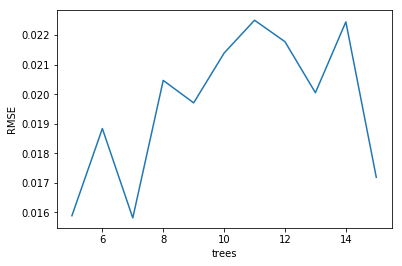

In [53]:
from sklearn.ensemble import RandomForestRegressor

trees = np.linspace(5,15,11)
trees = trees.astype(int)
#time series test train split
X_train1 = X_train.iloc[0:data_length-1-10,:]
X_test1 = X_train.iloc[data_length-1-10:,:]
y_train1 = y_train.iloc[0:data_length-1-10]
y_test1 = y_train.iloc[data_length-1-10:]

scores = []

for tree in trees:
    model = RandomForestRegressor(n_estimators=tree, criterion='mse', max_depth=None, 
                                  min_samples_split=2, min_samples_leaf=1, 
                                  max_features='auto', max_leaf_nodes=None, 
                                  bootstrap=True, oob_score=False, n_jobs=1, 
                                  random_state=None, verbose=0)
    model.fit(X_train1,y_train1)
    y_predict = model.predict(X_test1)
    #score = coeff_determination(y_test1,y_predict)
    score = RMSE_calc(y_predict,y_test1,10)
    scores.append(score)
    
plt.plot(trees,scores)
plt.xlabel('trees')
plt.ylabel('RMSE')
print(np.max(scores))
best_depth = trees[np.argmax(scores)]
print(best_depth)

In [54]:
#cross validate results
X_new = np.matrix(X_train)
y_new = y_train

model = RandomForestRegressor(n_estimators=best_depth, criterion='mse', max_depth=None, 
                                  min_samples_split=2, min_samples_leaf=1, 
                                  max_features='auto', max_leaf_nodes=None, 
                                  bootstrap=True, oob_score=False, n_jobs=1, 
                                  random_state=None, verbose=0)

from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=30)
i = 0
scores = []
for train_index, test_index in tss.split(X_new):
    #print('Train:', train_index, 'Test:', test_index)
    i += 1
    if i >= 26 and i < 30:
        X_train, X_test = X_new[train_index,:], X_new[test_index,:]
        y_train, y_test = y_new[train_index], y_new[test_index]
        model.fit(X_train,y_train)
        y_predict = model.predict(X_test)
        score = RMSE_calc(y_predict,y_test,y_test.shape[0])
        scores.append(score)
print(scores)

[0.023636945377646289, 0.016327479667037861, 0.014068545301486596, 0.01430546477832766]


In [55]:
#try GridSearchCV
from sklearn.model_selection import GridSearchCV 
model = RandomForestRegressor()

param_grid = { 
    'n_estimators': [5,6,7,8,9,10,11,12,13,14,15,20,30,50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [None, 4,5,6,7,8]}

CV_rf = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
CV_rf.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [None, 4, 5, 6, 7, 8], 'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 50], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [56]:
CV_rf.best_params_

{'max_depth': 8, 'max_features': 'auto', 'n_estimators': 6}

As seem above, the best features using GridSearchCV is the default features with 13 decision trees which is similar to what the RMSE vs trees plot shows above. As a result, 13 trees as n_estimators will be coded into the models below:

In [57]:
estimators = 6
model = RandomForestRegressor(n_estimators=estimators, criterion='mse', max_depth=None, 
                              min_samples_split=2, min_samples_leaf=2, 
                              max_features='auto', max_leaf_nodes=None, 
                              bootstrap=True, oob_score=False, n_jobs=1, 
                              random_state=None, verbose=0)
X_test = np.matrix(X3.iloc[-1,:])
model.fit(X_new,y_new)
y_predict = (model.predict(X_test))*((y_max-y_min)+y_min)
print(y_predict)

[ 161.12611334]


- Although the cross validation RMSE is similar to that of the RNN, the predicted answer is much lower and does not make much sense compared to the actual values from the original dataset and also from the output from the neural network. Additionally, it is shown that there is much more variance in this cross validation.

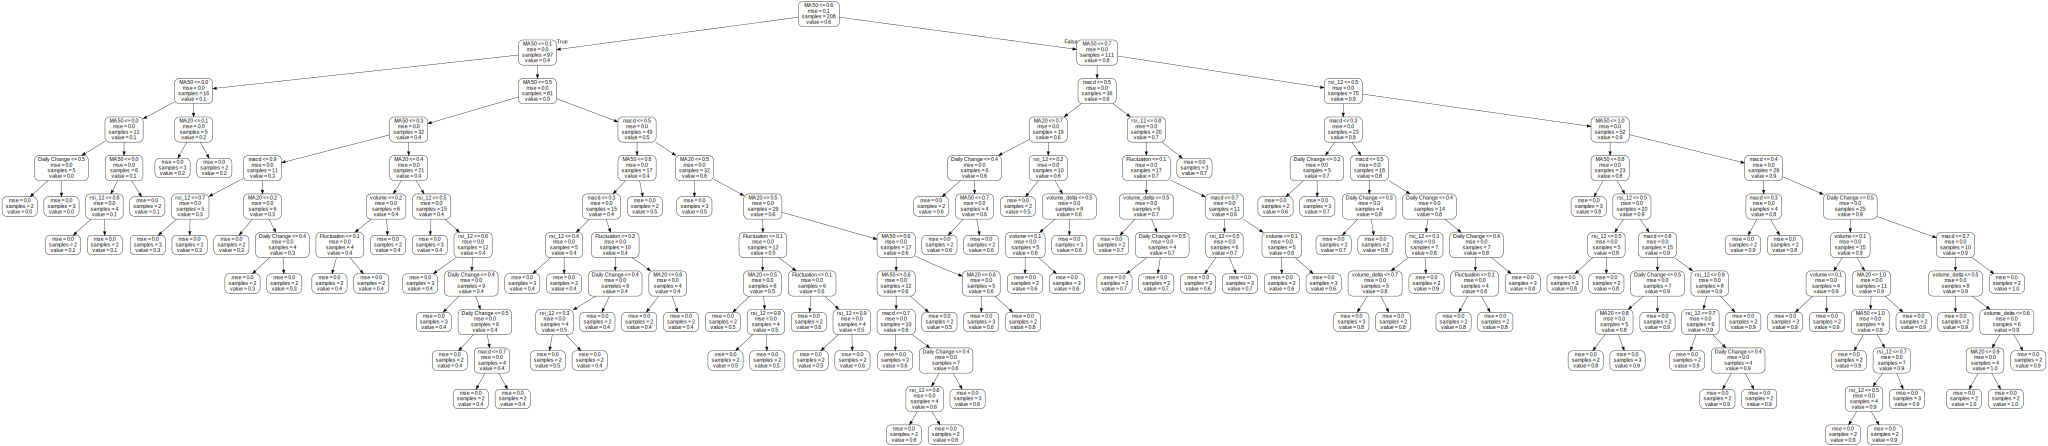

In [58]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
#import pydot
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image 
import graphviz
# Pull out one tree from the forest
tree = model.estimators_[5]
# Import tools needed for visualization
# Pull out one tree from the forest
tree = model.estimators_[5]
# Export the image to a dot file
dot_data = export_graphviz(tree, out_file = None, feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
graph = graphviz.Source(dot_data)
graph

In [59]:
#Decision based on prediction for 1 step forward
y_check = y[-1]*(y_max-y_min)+y_min

print('Based on previous value of:', y_check)
if y_check < y_predict:
    print('Buy')
elif y_check > y_predict:
    print('Sell if bought')
else:
    print('error')

Based on previous value of: 169.1
Sell if bought


In [60]:
#predict for 5 days ahead
X_train = X3.iloc[0:data_length-5,:]
X_test = np.matrix(X3.iloc[data_length-5:,:])
y_train = y_normal.iloc[5:]
y_train.shape

(329,)

In [62]:
X_new = np.matrix(X_train)
y_new = y_train

model = RandomForestRegressor(n_estimators=estimators, criterion='mse', max_depth=None, 
                                  min_samples_split=2, min_samples_leaf=1, 
                                  max_features='auto', max_leaf_nodes=None, 
                                  bootstrap=True, oob_score=False, n_jobs=1, 
                                  random_state=None, verbose=0)

from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=25)
i = 0
scores = []
for train_index, test_index in tss.split(X_new):
    #print('Train:', train_index, 'Test:', test_index)
    i += 1
    if i >= 21 and i < 25:
        X_train, X_test = X_new[train_index,:], X_new[test_index,:]
        y_train, y_test = y_new[train_index], y_new[test_index]
        model.fit(X_train,y_train)
        y_predict = model.predict(X_test)
        score = RMSE_calc(y_predict,y_test,y_test.shape[0])
        scores.append(score)
print(scores)

[0.021160129800160552, 0.04632097148877181, 0.023647229969599729, 0.029591372270330332]


In [63]:
model = RandomForestRegressor(n_estimators=best_depth, criterion='mse', max_depth=None, 
                              min_samples_split=2, min_samples_leaf=2, 
                              max_features='auto', max_leaf_nodes=None, 
                              bootstrap=True, oob_score=False, n_jobs=1, 
                              random_state=None, verbose=0)
X_test = np.matrix(X3.iloc[data_length-5:,:])
model.fit(X_new,y_new)
y_predict = (model.predict(X_test))*((y_max-y_min)+y_min)
print(y_predict[-1])

149.037221921


- Although it is shown that the RMSE is lower than that of the neural network, the random forests model maybe overfit the data because the values outputted do not match the original dataset very well. Therefore, this model cannot be used for the final web app because all of the values outputted give a lower price relative to the last price in the dataset

## ARIMA Model

In [65]:
y_normal.head() #ARIMA model only takes 1 input

date
2017-01-03    0.001874
2017-01-04    0.000000
2017-01-05    0.008504
2017-01-06    0.027243
2017-01-09    0.042810
Name: close, dtype: float64

In [66]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

def evaluate_arima_model(X,order):
    train_size = int(len(X)*0.9)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history,order=order)
        model_fit = model.fit(disp=0)
        y_pred = model_fit.forecast()[0]
        predictions.append(y_pred)
        history.append(test[t])
    error = mean_squared_error(test,predictions)
    return error


def evaluate_models(X,p_values,d_values,q_values):
    dataset = X.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset,order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA %s MSe=%.3f' %(order,mse))
                except:
                    continue
    print('Best ARIMA:%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg, best_score

p_values = [1, 2, 3]
d_values = range(0, 3)
q_values = range(0, 3)

D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [114]:
best_cfg, best_score = evaluate_models(y_normal, p_values, d_values, q_values)
#takes long time to run, only ran once previously and used results in subsequent models:
import warnings
warnings.filterwarnings("ignore")

D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) MSe=0.002
ARIMA (1, 0, 1) MSe=0.002
ARIMA (1, 0, 2) MSe=0.002
ARIMA (1, 1, 0) MSe=0.002
ARIMA (1, 2, 0) MSe=0.003


D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 1) MSe=0.002


D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or co

ARIMA (2, 0, 0) MSe=0.002
ARIMA (2, 0, 1) MSe=0.002
ARIMA (2, 0, 2) MSe=0.002
ARIMA (2, 1, 0) MSe=0.002
ARIMA (2, 1, 1) MSe=0.002


D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 0) MSe=0.003


D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to c

ARIMA (2, 2, 1) MSe=0.002


D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to c

ARIMA (2, 2, 2) MSe=0.002
ARIMA (3, 0, 0) MSe=0.002
ARIMA (3, 0, 1) MSe=0.002


D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to c

ARIMA (3, 0, 2) MSe=0.002
ARIMA (3, 1, 0) MSe=0.002


D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 1) MSe=0.002


D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to c

ARIMA (3, 1, 2) MSe=0.002
ARIMA (3, 2, 0) MSe=0.002


D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to c

ARIMA (3, 2, 2) MSe=0.002
Best ARIMA:(3, 1, 2) MSE=0.002


In [67]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def coeff_determination(y_true,y_pred):
    SS_res = np.sum((y_true-y_pred)**2)
    SS_tot = np.sum((y_true-np.mean(y_true))**2)
    return(np.abs(1-SS_res/(SS_tot+1e-18)))

Day 1: 0.895951


D:\python_Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


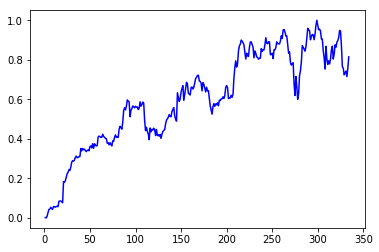

In [68]:
series = y_normal
# seasonal difference
X = series.values
days_in_year = 52 #rough timeframe per season
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(3,1,2)) #from results of Best ARMIA coefficients
model_fit = model.fit(disp=0)

future_steps = 1
# multistep future forecast
forecast = model_fit.forecast(steps=future_steps)[0]
# invert the differenced forecast to something usable
y_predict = [x for x in X]
day = 1

for yhat in forecast:
    inverted = inverse_difference(y_predict, yhat, days_in_year)
    print('Day %d: %f' % (day, inverted))
    y_predict.append(inverted)
    day += 1

y_predict = np.array(y_predict)
plt.figure()
days = np.linspace(1,y_predict.shape[0],y_predict.shape[0])
pred_len = y_predict.shape[0]
plt.plot(days[0:pred_len-future_steps],y_predict[0:pred_len-future_steps],color='b')
plt.plot(days[pred_len-future_steps:],y_predict[pred_len-future_steps:],color='r')

In [69]:
y_predict_scaled = y_predict[-1]*(y_max-y_min)+y_min
print(y_predict_scaled)

#Decision based on prediction for 1 day in future
y_check = y[-1]*(y_max-y_min)+y_min

print('Based on previous value of:', y_check)
if y_check < y_predict_scaled:
    print('Buy')
elif y_check > y_predict_scaled:
    print('Sell if bought')
else:
    print('error')

174.644665477
Based on previous value of: 169.1
Buy


In [70]:
time_length = y_normal.shape[0]

def time_series_test_train(X,length):
    #automatically choses CV length at 10
    CV = 10
    X_train = X[0:length]
    X_CV = X[length:length+10]
    return [X_train, X_CV]

def RMSE_calc(X_train,X_CV,length,forward_steps):
    X = X_train.values
    days_in_year = 52
    differenced = difference(X, days_in_year)
    # fit model
    model = ARIMA(differenced, order=(2,1,1))
    model_fit = model.fit(disp=0)
    future_steps = forward_steps
    forecast = model_fit.forecast(steps=future_steps)[0]
    y_predict = [x for x in X]
    day = 1
    
    for yhat in forecast:
        inverted = inverse_difference(y_predict, yhat, days_in_year)
        y_predict.append(inverted)
        day += 1

    y_predict = np.array(y_predict)
    y_validation = y_predict[length:]
    y_validation_scaled = np.ravel(np.array(y_validation))
    y_actual_scaled = np.array(np.array(X_CV))
    RMSE = ((np.sum((y_validation_scaled-y_actual_scaled)**(2)))**(0.5))/10
    return RMSE

In [71]:
#Cross validation on time series for 4 folds
X_train1, X_CV1 = time_series_test_train(y,time_length-40)
RMSE1 = RMSE_calc(X_train1,X_CV1,time_length-40,1)
print(RMSE1)

X_train2, X_CV2 = time_series_test_train(y,time_length-30)
RMSE2 = RMSE_calc(X_train2,X_CV2,time_length-30,1)
print(RMSE2)

X_train3, X_CV3 = time_series_test_train(y,time_length-20)
RMSE3 = RMSE_calc(X_train3,X_CV3,time_length-20,1)
print(RMSE3)

X_train4, X_CV4 = time_series_test_train(y,time_length-10)
RMSE4 = RMSE_calc(X_train4,X_CV4,time_length-10,1)
print(RMSE4)

0.0105641570316
0.0311621133169
0.0252263794814
0.0577736573436


- Overall, the cross validation shows that for a 1 step model, the RMSE gets worse as the time series progresses and the variance seems high. The RMSE is roughly similar to that of the RNN LTSM model. Furthermore, the ARIMA model cannot account for additional features that can be mathmatically derived from the stock prices initial dataset. 

Day 1: 0.895986
Day 2: 0.886514
Day 3: 0.876745
Day 4: 0.864034
Day 5: 0.883824


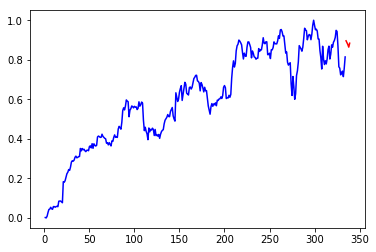

In [72]:
#try 5 days forward
series = y
# seasonal difference
X = series.values
days_in_year = 52
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(1,1,0))
model_fit = model.fit(disp=0)

future_steps = 5
# multistep future forecast
forecast = model_fit.forecast(steps=future_steps)[0]
# invert the differenced forecast to something usable
y_predict = [x for x in X]
day = 1

for yhat in forecast:
    inverted = inverse_difference(y_predict, yhat, days_in_year)
    print('Day %d: %f' % (day, inverted))
    y_predict.append(inverted)
    day += 1

y_predict = np.array(y_predict)
plt.figure()
days = np.linspace(1,y_predict.shape[0],y_predict.shape[0])
pred_len = y_predict.shape[0]
plt.plot(days[0:pred_len-future_steps],y_predict[0:pred_len-future_steps],color='b')
plt.plot(days[pred_len-future_steps:],y_predict[pred_len-future_steps:],color='r')

In [74]:
y_predict_scaled = y_predict[-1]*(y_max-y_min)+y_min
print(y_predict_scaled)

#Decision based on prediction for 5 days in future
y_check = y[-1]*(y_max-y_min)+y_min

print('Based on previous value of:', y_check)
if y_check < y_predict_scaled:
    print('Buy')
elif y_check > y_predict_scaled:
    print('Sell if bought')
else:
    print('error')

173.82004653
Based on previous value of: 169.1
Buy


In [75]:
X_train1, X_CV1 = time_series_test_train(y,time_length-45)
RMSE1 = RMSE_calc(X_train1,X_CV1,time_length-50,5)
print(RMSE1)

X_train2, X_CV2 = time_series_test_train(y,time_length-35)
RMSE2 = RMSE_calc(X_train2,X_CV2,time_length-40,5)
print(RMSE2)

X_train3, X_CV3 = time_series_test_train(y,time_length-25)
RMSE3 = RMSE_calc(X_train3,X_CV3,time_length-30,5)
print(RMSE3)

X_train4, X_CV4 = time_series_test_train(y,time_length-15)
RMSE4 = RMSE_calc(X_train4,X_CV4,time_length-20,5)
print(RMSE4)

0.0198125286796
0.0258505830745
0.0188571420809
0.0197364164442


- The RMSE for this model for a 5 step prediction is much lower and more consistent than that of the 1 step prediction. However, the final prediction results is very similar to the LSTM model, so the LSTM model will be used for 1 day and 5 day predictions on the web app.

175.898589841
Based on previous value of: 169.1
Buy


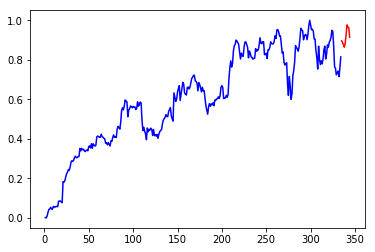

In [76]:
#try 10 days forward
series = y
# seasonal difference
X = series.values
days_in_year = 52
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(1,1,0))
model_fit = model.fit(disp=0)

future_steps = 10
# multistep future forecast
forecast = model_fit.forecast(steps=future_steps)[0]
# invert the differenced forecast to something usable
y_predict = [x for x in X]
day = 1

for yhat in forecast:
    inverted = inverse_difference(y_predict, yhat, days_in_year)
    #print('Day %d: %f' % (day, inverted))
    y_predict.append(inverted)
    day += 1

y_predict = np.array(y_predict)
plt.figure()
days = np.linspace(1,y_predict.shape[0],y_predict.shape[0])
pred_len = y_predict.shape[0]
plt.plot(days[0:pred_len-future_steps],y_predict[0:pred_len-future_steps],color='b')
plt.plot(days[pred_len-future_steps:],y_predict[pred_len-future_steps:],color='r')


y_predict_scaled = y_predict[-1]*(y_max-y_min)+y_min
print(y_predict_scaled)

#Decision based on prediction for 10 days in future
y_check = y[-1]*(y_max-y_min)+y_min

print('Based on previous value of:', y_check)
if y_check < y_predict_scaled:
    print('Buy')
elif y_check > y_predict_scaled:
    print('Sell if bought')
else:
    print('error')

In [77]:
X_train1, X_CV1 = time_series_test_train(y,time_length-45)
RMSE1 = RMSE_calc(X_train1,X_CV1,time_length-45,10)
print(RMSE1)

X_train2, X_CV2 = time_series_test_train(y,time_length-35)
RMSE2 = RMSE_calc(X_train2,X_CV2,time_length-35,10)
print(RMSE2)

X_train3, X_CV3 = time_series_test_train(y,time_length-25)
RMSE3 = RMSE_calc(X_train3,X_CV3,time_length-25,10)
print(RMSE3)

X_train4, X_CV4 = time_series_test_train(y,time_length-15)
RMSE4 = RMSE_calc(X_train4,X_CV4,time_length-15,10)
print(RMSE4)

0.0253457707286
0.0333147652068
0.0267134919624
0.0451839200914


- As the time series progresses, the RMSE seems to increase in the 10 step prediction. However, the RMSE is still similar to the 5 step LSTM prediction, so this model can be used for a long term prediction on the web app.